In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

!pip install pydicom

import sys
!{sys.executable} -m pip install --quiet --no-cache-dir --upgrade pip

import sys
!{sys.executable} -m pip install opencv-python

In [2]:
import numpy as np #    
import matplotlib
import tkinter

import pylab # модуль для построения графиков
import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

In [4]:
import pydicom
from skimage.transform import rotate

<h1 style="color:DodgerBlue;">1. Общие действия</h1>

<h4 style="color:Blue;">1.1 количество снимков в полученной папке 'unhealthy'</h4>

In [5]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy'
photo_count = count_photos(folder_path)
print(photo_count)

1113


<h4 style="color:Blue;">1.2 анализ файлов в папке 'unhealthy''</h4>

#### 1.2.1 серия 0002

In [6]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0002-00808.dcm"
dcm_data = pydicom.dcmread(dcm_file)

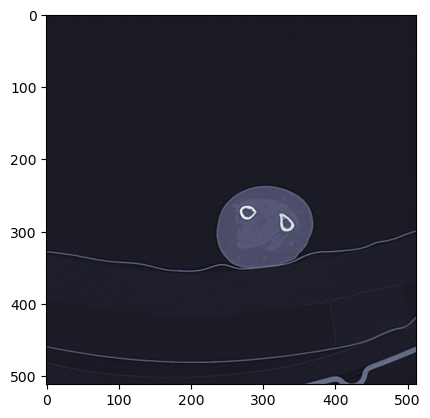

In [7]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

#### 1.2.2 серия 0003

In [8]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0003-00001.dcm"
dcm_data = pydicom.dcmread(dcm_file)

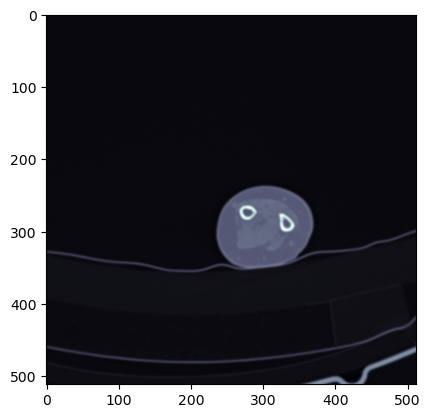

In [9]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

<span style="color: red;">**Зеркальный файл и зеркальная серия. Удалить**</span>

<h5 style="color:green;">УСТАНОВКА НОВЫХ БИБЛИОТЕК,   БИБЛИОТЕКИ ДЛЯ 3D ВИЗУАЛИЗАЦИИ 'vtk' И 'mayavi'</h5>

<h4 style="color:Blue;">1.3 создание папки "unhealthy1", содержащей только файлы серии 0002'</h4>

In [10]:
import shutil

# Директория с исходными DICOM файлами
source_directory = 'unhealthy'
# Директория для файлов серии 0002
destination_directory = 'unhealthy1'

# Создание новой директории, если она не существует
os.makedirs(destination_directory, exist_ok=True)

# Список всех файлов в исходной директории
files = os.listdir(source_directory)

# Фильтрация и копирование файлов серии 0002
for file_name in files:
    if '0002' in file_name:
        source_file = os.path.join(source_directory, file_name)
        destination_file = os.path.join(destination_directory, file_name)
        shutil.copy2(source_file, destination_file)

print("Files from series 0002 have been copied to the new directory.")

Files from series 0002 have been copied to the new directory.


In [11]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy1'
photo_count = count_photos(folder_path)
print(photo_count)

819


<h4 style="color:Blue;">1.4 проверка наличия пиксельных данных и удаление пустых файлов'</h4>

In [12]:
# Директория с DICOM файлами
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]

print(f"Found {len(files)} DICOM files in the directory.")

Found 819 DICOM files in the directory.


In [13]:
files_without_images = []

for file_name in files:
    file_path = os.path.join(directory, file_name)
    try:
        dcm = pydicom.dcmread(file_path)
        if not hasattr(dcm, 'PixelData'):
            print(f"File {file_name} does not contain image data. Deleting...")
            os.remove(file_path)
            files_without_images.append(file_name)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

print(f"Removed {len(files_without_images)} files that do not contain image data.")

Removed 0 files that do not contain image data.


<h1 style="color:DodgerBlue;">2. Проверки и преобразования массива</h1>

<h4 style="color:Blue;">2.1 Проверка размеров изображений'</h4>

Перед визуализацией проверить все ли изображения имеют одинаковые размеры.

In [14]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

In [15]:
# Проверка размеров изображений
sizes = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    sizes.append(dcm.pixel_array.shape)

In [16]:
unique_sizes = set(sizes)
print(f"Unique image sizes: {unique_sizes}")

if len(unique_sizes) > 1:
    print("Warning: Not all DICOM files have the same size.")

Unique image sizes: {(512, 512)}


<h4 style="color:Blue;">2.2 Нормализация изображений</h4>

Если размеры не совпадают, нормализовать их до одного размера

In [17]:
from skimage.transform import resize

# Выберем минимальные размеры как базовые
base_height, base_width = min(sizes)
# Можно также выбрать максимальные размеры для базовых, чтобы избежать потерь данных
# base_height, base_width = max(sizes)

resized_slices = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    image = dcm.pixel_array
    if image.shape != (base_height, base_width):
        image_resized = resize(image, (base_height, base_width), anti_aliasing=True)
        image_resized = (image_resized * 65535).astype(np.uint16)  # Приведение к типу данных DICOM
    else:
        image_resized = image
    
    resized_slices.append(image_resized)

volume = np.stack(resized_slices, axis=-1)

<h4 style="color:Blue;">2.3 Проверка ориентации и позиционирования</h4>

DICOM файлы могут содержать информацию о положении и ориентации изображений. Ориентируем изображения по оси Z предварительно сортируя их

In [18]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    return dcm.pixel_array, dcm.ImagePositionPatient

# Читаем все DICOM файлы и получаем их ImagePositionPatient атрибут и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (ось пациента)

volume = np.stack([s[0] for s in slices], axis=-1)

Проверка наличия атрибута: Добавить проверку наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [19]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume = np.stack([s[0] for s in slices], axis=-1)
print(volume.shape)

(512, 512, 819)


<h1 style="color:DodgerBlue;">3. Визуализация по стандартным проекцим</h1>

<h4 style="color:Blue;">3.1 Прямая визуализация с исходной контрастностью</h4>

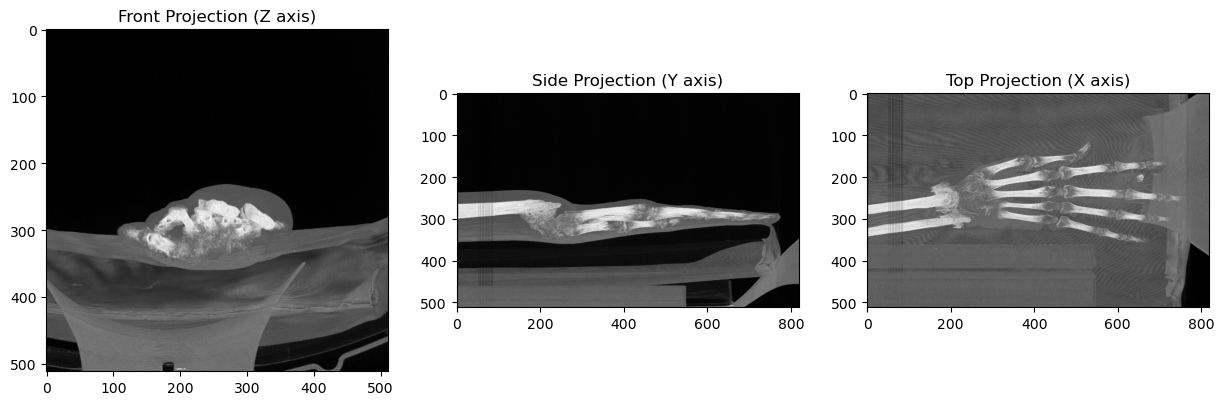

In [20]:
projection_z = np.max(volume, axis=2) # Front projection (по оси Z)
projection_y = np.max(volume, axis=1) # Side projection (по оси Y)
projection_x = np.max(volume, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h1 style="color:DodgerBlue;">4. Числовые значения в проекциях массива</h1>

<h4 style="color:Blue;">4.1 Top projection (по оси X)</h4>

In [21]:
# Top projection (по оси X)
projection_x = np.max(volume, axis=0)

In [22]:
projection_x

array([[8355, 8389, 8374, ..., 8733, 8708, 8686],
       [8317, 8406, 8403, ..., 8660, 8655, 8678],
       [8296, 8339, 8326, ..., 8681, 8712, 8715],
       ...,
       [8649, 8620, 8625, ..., 7257, 7234, 7238],
       [8633, 8628, 8600, ..., 7260, 7249, 7260],
       [8677, 8718, 8675, ..., 7287, 7250, 7262]], dtype=uint16)

In [23]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


<span style="color: red;">**Нулей нет даже на чёрном**</span>

In [24]:
projection_x.shape

(512, 819)

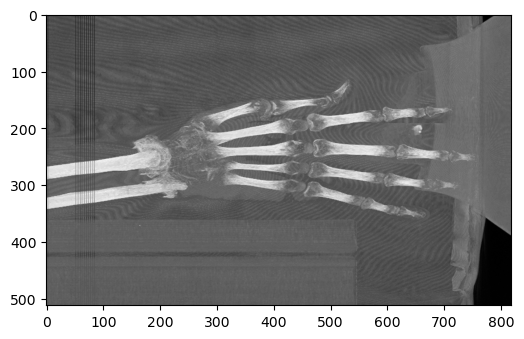

In [25]:
from skimage.transform import rotate
plt.figure(figsize=(6, 6))
plt.imshow(projection_x,cmap='gray')
plt.show()

<h4 style="color:Blue;">4.2 Проверка значений в массиве по координатам</h4>

In [26]:
projection_x[100][750]

8891

In [27]:
projection_x[500][800]

7252

In [28]:
projection_x[275][5]

10528

<h4 style="color:Blue;">4.3 Расчёты для преобразования в стандартные значения пикселей</h4>

In [29]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


In [30]:
# разность значений
p = projection_x.max() - projection_x.min()
p

3807

In [31]:
# Соотношение значений пикселей
s = int(p / 256 + 1)
s

15

In [32]:
# приведённый массив "с нулями в минимуме"
projection_xp = projection_x - 7217
projection_xp

array([[1138, 1172, 1157, ..., 1516, 1491, 1469],
       [1100, 1189, 1186, ..., 1443, 1438, 1461],
       [1079, 1122, 1109, ..., 1464, 1495, 1498],
       ...,
       [1432, 1403, 1408, ...,   40,   17,   21],
       [1416, 1411, 1383, ...,   43,   32,   43],
       [1460, 1501, 1458, ...,   70,   33,   45]], dtype=uint16)

In [33]:
# приведённый массив к размерности значений пикселей .png
projection_xpp = np.floor(projection_xp / s) # ceil
projection_xpp

array([[ 75.,  78.,  77., ..., 101.,  99.,  97.],
       [ 73.,  79.,  79., ...,  96.,  95.,  97.],
       [ 71.,  74.,  73., ...,  97.,  99.,  99.],
       ...,
       [ 95.,  93.,  93., ...,   2.,   1.,   1.],
       [ 94.,  94.,  92., ...,   2.,   2.,   2.],
       [ 97., 100.,  97., ...,   4.,   2.,   3.]])

In [34]:
print(projection_xpp.max())
print(projection_xpp.min())
print(projection_xpp.mean())

253.0
0.0
97.63804229624542


<h1 style="color:DodgerBlue;">5. Перевод изображения в формат .png</h1>

<h4 style="color:Blue;">5.1 сохранение изображения В РАЗМЕРЕ МАССИВА и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ</h4>

In [35]:
projection_xpp = projection_xpp.astype(np.uint8)
image = Image.fromarray(projection_xpp)
image.save('image1_s.png') # Сохранение изображения в файл .png

In [36]:
image = cv2.imread('image1_s.png') 
height, width, channels = image.shape # Получение размера изображения
print(f"Размер изображения: {width}x{height} пикселей")

Размер изображения: 819x512 пикселей


In [37]:
image = cv2.imread('image1_s.png')
num_channels = image.shape[2] # Получение количества каналов
print(f"Количество слоев (каналов) в изображении: {num_channels}")

Количество слоев (каналов) в изображении: 3


<span style="color: red;">**изображение является цветным (RGB)**</span>

<h4 style="color:Blue;">5.2 Преобразовать изображение в одноканальное (оттенки серого)</h4>

In [38]:
image = cv2.imread('image1_s.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Преобразование изображения в оттенки серого
print(gray_image.shape) 
print(gray_image.ndim)  # 2 = одноканальное изображение
cv2.imwrite('gray_image1_s.png', gray_image) # Сохранение одноканального изображения

(512, 819)
2


True

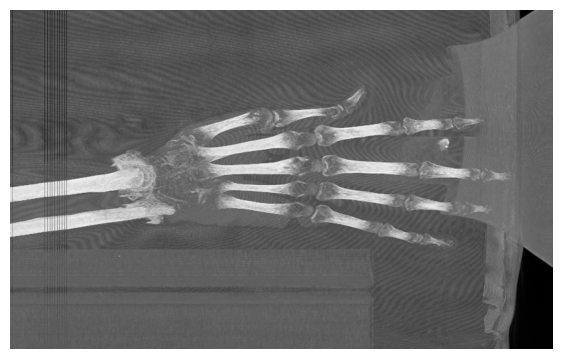

In [39]:
gray_image = mpimg.imread('gray_image1_s.png')
# Отображение изображения в оттенках серого
plt.figure(figsize=(7, 7))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

<h4 style="color:Blue;">5.3 создание и сохранение контрастного изображения</h4>

In [40]:
image22 = Image.open('gray_image1_s.png')
enhancer = ImageEnhance.Contrast(image22) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(3.0) # Увеличение контрастности в 3 раза
enhanced_image.save('image1_contrast_s.png')

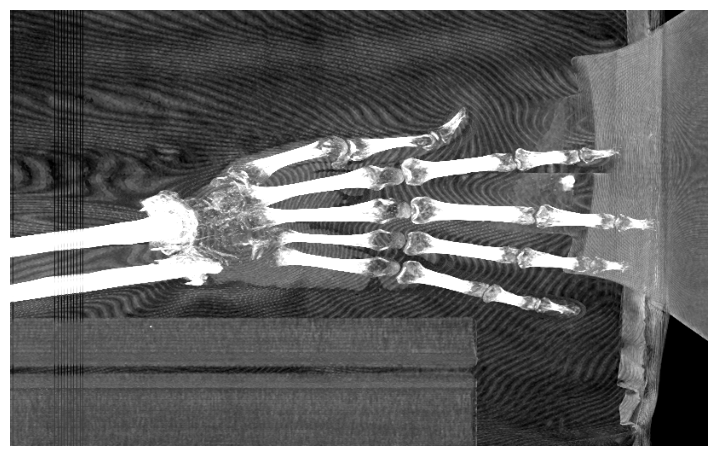

In [41]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('image1_contrast_s.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71, cmap='gray') # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h1 style="color:DodgerBlue;">6. Определение угла между осью исследуемой кости и горизонтом для поворота</h1>

In [42]:
import cv2
import numpy as np

# Чтение изображения
image = cv2.imread('image1_contrast_s.png')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: image1_contrast.png')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
drawing = False

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.2f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('image1_contrast_edited_s.png', overlay)

cv2.destroyAllWindows()

Угол между линией №1 и горизонтом: 5.92 градусов
Горизонтальная линия нарисована через точку: (774, 161)


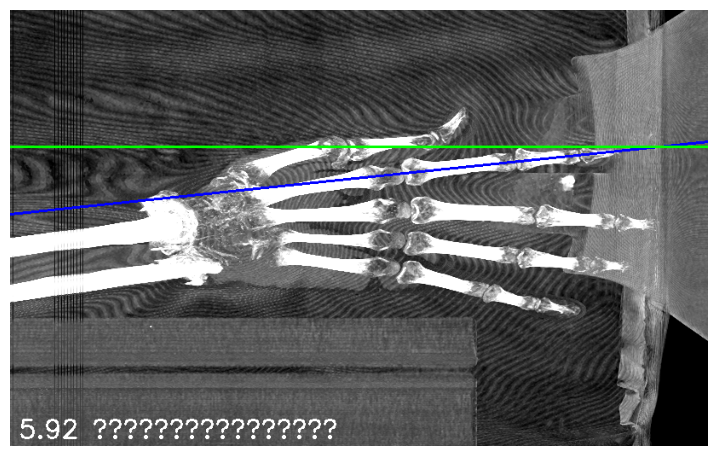

In [43]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('image1_contrast_edited_s.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h1 style="color:DodgerBlue;">7. Поворот X и Y плоскостей вокруг оси Y с заданным углом поворота = получение  rotated_volume</h1>

Original volume shape: (512, 512, 819)
Rotated volume shape: (512, 512, 819)


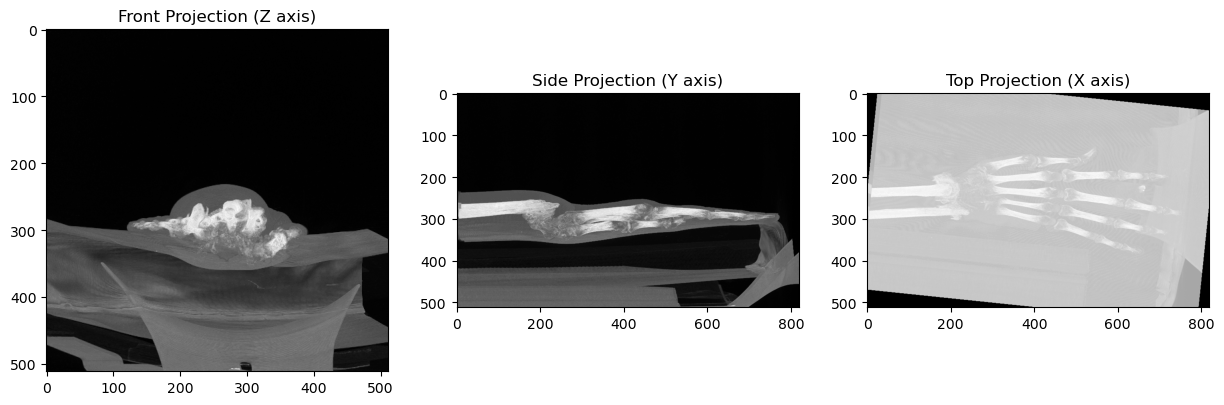

In [44]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'unhealthy1'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = 5.92

# Поворот объёма вокруг оси Z
rotated_volume = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume.shape)

# Получение проекций после поворота
projection_x1, projection_y1, projection_z1 = get_projections(rotated_volume)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_z1, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y1, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x1, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


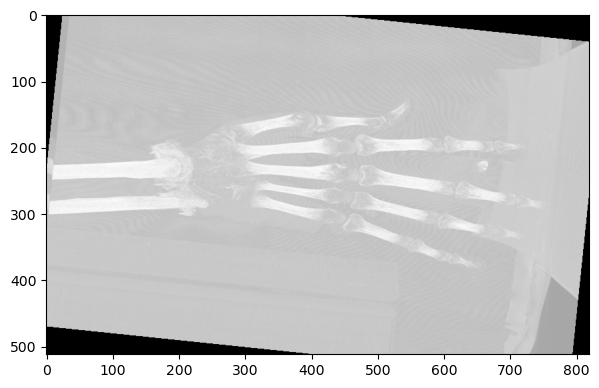

In [45]:
from skimage.transform import rotate
plt.figure(figsize=(7, 7))
plt.imshow(projection_x1,cmap='gray')
plt.show()

<h1 style="color:DodgerBlue;">8. Преобразования значений в повёрнутых массиве и соответственно повёрнутых проекциях массива 'rotated_volume'</h1>

<h4 style="color:Blue;">8.1 значения элементов в проекции массива 'rotated_volume'</h4>

In [46]:
projection_x1[10][800]

0

In [47]:
projection_x1[100][296]

8494

In [48]:
projection_x1[275][100]

9140

In [49]:
projection_x1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [50]:
print(projection_x1.max())
print(projection_x1.min())
print(projection_x1.mean())

11034
0
8237.97414196047


<span style="color: Crimson;">**8.2 Появились нули из-за поворота массива, поэтому преобразовать тип uint16 в int32 для избежания ошибок на месте нулей**</span>

In [51]:
# ИНАЧЕ НЕ ВЫЧИТАЕТСЯ НОРМАЛЬНО
projection_x1_int32 = projection_x1.astype(np.int32)

In [52]:
# Выполнение вычитания
subtract_value = 7214 # Значение для вычитания
projection_x11 = projection_x1_int32 - subtract_value

In [53]:
projection_x11

array([[-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       ...,
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214]])

In [54]:
# Замена элементов со значением -7214 на нули
projection_x11[projection_x11 < 0] = 0

In [55]:
projection_x11

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [56]:
print(projection_x11.max())
print(projection_x11.min())
print(projection_x11.mean())

3820
0
1413.3974668994201


In [57]:
p = projection_x1.max() - subtract_value
p

3820

In [58]:
# Соотношение значений пикселей
s = int(p / 256 + 1)
s

15

In [59]:
# приведённый массив к размерности .png
projection_xp11 = np.floor(projection_x11 / s) # ceil
projection_xp11

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
print(projection_xp11.max())
print(projection_xp11.min())
print(projection_xp11.mean())

254.0
0.0
93.7847651480464


<h1 style="color:DodgerBlue;">9. Преобразование повернутых изображений в .png</h1>

<h4 style="color:Blue;">9.1 сохранение обычного изображения В РАЗМЕРЕ МАССИВА и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ</h4>

In [61]:
projection_xp11 = projection_xp11.astype(np.uint8)
image11 = Image.fromarray(projection_xp11)
image11.save('image11_s.png') # Сохранение изображения в файл .png

In [62]:
image = cv2.imread('image11_s.png')
height, width, channels = image.shape # Получение размера изображения
print(f"Размер изображения: {width}x{height} пикселей")

Размер изображения: 819x512 пикселей


In [63]:
image111 = cv2.imread('image11_s.png')
num_channels = image111.shape[2] # Получение количества каналов
print(f"Количество слоев (каналов) в изображении: {num_channels}")

Количество слоев (каналов) в изображении: 3


<h4 style="color:Blue;">9.2 Преобразовать изображение в одноканальное (оттенки серого)</h4>

In [65]:
image = cv2.imread('image11_s.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Преобразование изображения в оттенки серого
print(gray_image.shape)  # Выведет: (512, 819) # Размер преобразованного изображения
print(gray_image.ndim)  # Выведет: 2 (одноканальное изображение)
cv2.imwrite('gray_image11_s.png', gray_image) # Сохранение одноканального изображения

(512, 819)
2


True

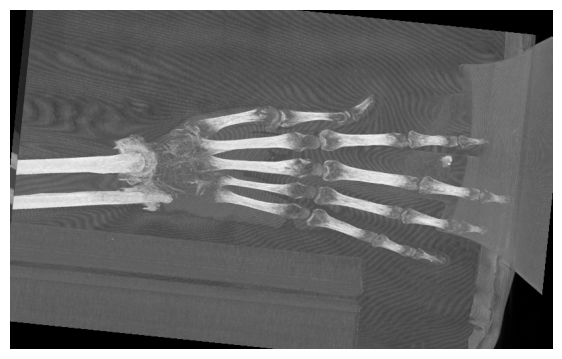

In [66]:
gray_image = mpimg.imread('gray_image11_s.png')
# Отображение изображения в оттенках серого
plt.figure(figsize=(7, 7))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

<h1 style="color:DodgerBlue;">10. Построение СЕЧЕНИЯ выбранной кости</h1>

<h4 style="color:Blue;">10.1 определение координаты вертикальной плоскости сечения выбранной кости</h4>

In [67]:
image = cv2.imread('gray_image11_s.png')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (487, 198)


<span style="color: Crimson;">**координата сечения (то есть индекса искомого двумерного массива в трёхмерном) = 198 по оси X**</span>

<h4 style="color:Blue;">10.1 Транспонирование повернутого трехмерного массива в нужную форму для получения искомых сечений</h4>

In [68]:
vol = np.transpose(rotated_volume, (1, 2, 0))

In [69]:
vol.shape

(512, 819, 512)

<h4 style="color:Blue;">10.2 Преобразование значений массива vol к пиксельным значениям формата png</h4>

In [70]:
# ИНАЧЕ НЕ ВЫЧИТАЕТСЯ НОРМАЛЬНО
vol_int32 = vol.astype(np.int32)

In [71]:
print(vol_int32.max())
print(vol_int32.min())

11034
0


In [72]:
# Выполнение вычитания
subtract_value = 7214 # Значение для вычитания
vol_int = vol_int32 - subtract_value

In [73]:
vol_int

array([[[-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        ...,
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214]],

       [[-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        ...,
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214]],

       [[-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        ...,
        [-7214, -7214, -7214, ..., -7214, -7214, -7214],
        [-7214, -7214, -7214, ..., -7214, -72

In [74]:
# Замена элементов со значением -7214 на нули
vol_int[vol_int < 0] = 0

In [75]:
print(vol_int.max())
print(vol_int.min())
print(vol_int.mean())

3820
0
58.768641838660606


In [76]:
# Соотношение значений пикселей
s = int(vol_int.max() / 256 + 1)
s

15

In [77]:
# приведённый массив к размерности .png
vol_png = np.floor(vol_int / s) # ceil

In [78]:
print(vol_png.max())
print(vol_png.min())
print(vol_png.mean())

254.0
0.0
3.7928697076035944


<h1 style="color:red;">11. Cечение выбранной кости</h1>

In [81]:
pict = vol_png[198]

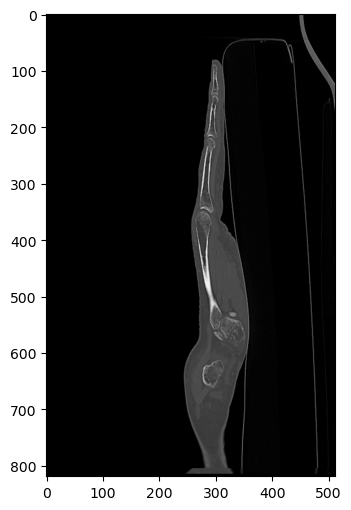

In [82]:
from skimage.transform import rotate
plt.figure(figsize=(6, 6))
plt.imshow(pict,cmap='gray')
plt.show()

In [83]:
pict = pict.astype(np.uint8)
image_pict = Image.fromarray(pict)
# Сохранение изображения в файл .png
image_pict.save('image_pict_s.png')

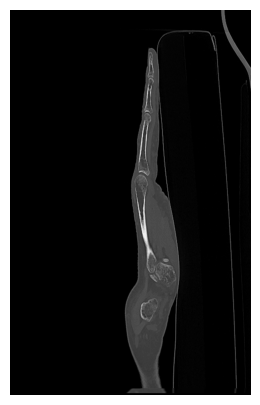

In [84]:
image_pict = mpimg.imread('image_pict_s.png')
# Отображение изображения в оттенках серого
plt.figure(figsize=(5, 5))
plt.imshow(image_pict, cmap='gray')
plt.axis('off')
plt.show()

<h4 style="color:Blue;">11.1 Поворот сечения на 90 градусов</h4>

In [85]:
input_path = 'image_pict_s.png'
output_path = 'image_pict_rotated_s.png'

image = Image.open(input_path)
rotated_image = image.rotate(-90, expand=True) # Поворот изображения на 90 градусов по часовой стрелки
rotated_image.save(output_path) # Сохранение преобразованного изображения
print(f"Image saved to {output_path}")

Image saved to image_pict_rotated_s.png


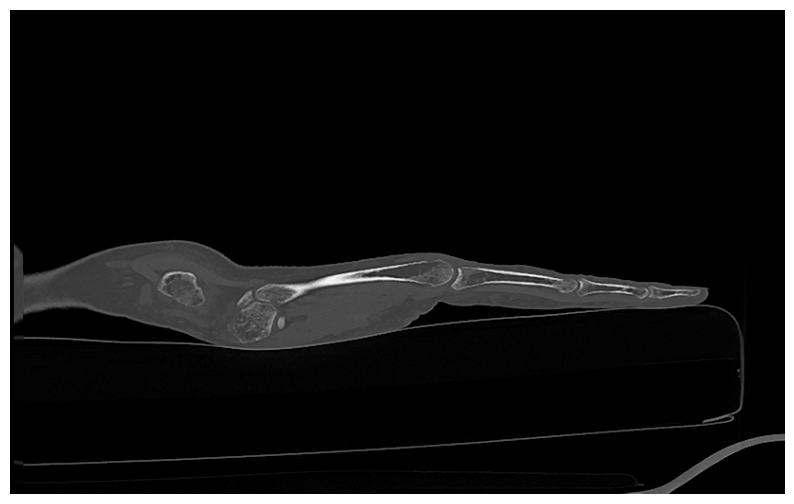

In [86]:
image_pict_rotated = mpimg.imread('image_pict_rotated_s.png')
# Отображение изображения в оттенках серого
plt.figure(figsize=(10, 10))
plt.imshow(image_pict_rotated, cmap='gray')
plt.axis('off')
plt.show()

<h1 style="color:DodgerBlue;">12. Вырезка части изображения - выбранной кости</h1>

In [87]:
matplotlib.use('TkAgg')  # Используйте TkAgg backend
plt.figure(figsize=(15, 15))

                
def crop_image(image, coords):
    cropped_image = image.crop(coords)
    return cropped_image

def get_coords(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    coords = plt.ginput(4)
    plt.close()
    return coords

image_path = 'image_pict_rotated_s.png'
image = Image.open(image_path)
enhancer = ImageEnhance.Contrast(image) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(1.0) # Увеличение контрастности в 2 раза
coords = get_coords(image_path)

x_coordinates = sorted([int(coord[0]) for coord in coords])
y_coordinates = sorted([int(coord[1]) for coord in coords])
    
x1, y1 = x_coordinates[0], y_coordinates[0]
x2, y2 = x_coordinates[3], y_coordinates[3]
        
plt.figure(figsize=(15, 15))
image = Image.open(image_path)
cropped_image = crop_image(image, (x1, y1, x2, y2))
               
#output_path = os.path.join(output_folder, file_name)
cropped_image.save('the_desired_picture_s.png')

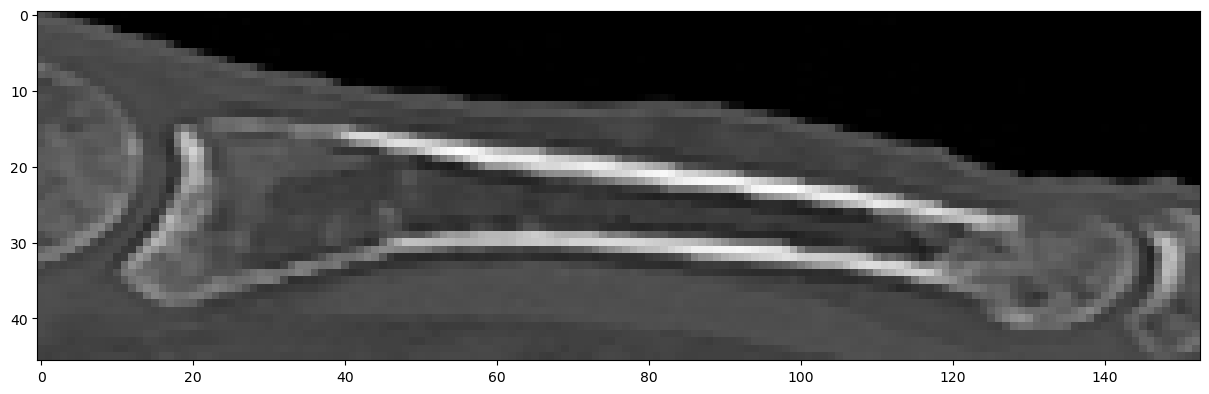

In [91]:
%matplotlib inline
plt.figure(figsize=(15, 15))
image_11 = Image.open('the_desired_picture_s.png')
plt.imshow(image_11, cmap='gray') #
plt.show()

In [92]:
image = cv2.imread('the_desired_picture_s.png')
#gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Преобразование изображения в оттенки серого
print(image.shape) 
print(image.ndim)  # 2 = одноканальное изображение
#cv2.imwrite('gray_image1.png', gray_image) # Сохранение одноканального изображения

(46, 153, 3)
3


In [94]:
image111 = cv2.imread('the_desired_picture_s.png')
image111.shape

(46, 153, 3)

In [98]:
image = cv2.imread('the_desired_picture_s.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Преобразование изображения в оттенки серого
print(gray_image.shape)  # Выведет: (512, 819) # Размер преобразованного изображения
print(gray_image.ndim)  # Выведет: 2 (одноканальное изображение)
cv2.imwrite('gray_desired_picture_s.png', gray_image) # Сохранение одноканального изображения

(46, 153)
2


True

In [125]:
image22 = Image.open('the_desired_picture_s.png')
enhancer = ImageEnhance.Contrast(image22) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(4.0) # Увеличение контрастности в 3 раза
enhanced_image.save('the_desired_picture_contrast_s.png')

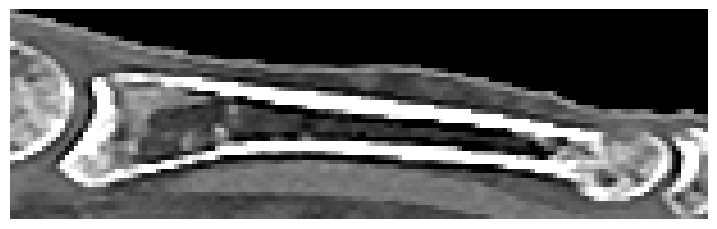

In [126]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('the_desired_picture_contrast_s.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71, cmap='gray') # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

# 9. Вывод врачом если требуется расстояния между точками на изображении (цена деления пикселя в этом примере произвольная)

In [136]:
matplotlib.use('TkAgg')  # Используйте TkAgg backend
# 1) Загрузка изображения
image_path = "the_desired_picture_contrast_s.png"  # Замените на путь к вашему изображению
image = plt.imread(image_path)

# Отображение изображения на экране во всплывающем окне
fig, ax = plt.subplots()
ax.imshow(image)

# 2) Пометка двух точек на изображении
points = []

def onclick(event):
    if len(points) < 2:
        x, y = event.xdata, event.ydata
        ax.plot(x, y, 'ro')  # Пометка точки красным кругом
        points.append((x, y))
        if len(points) == 2:
            # 3) Определение расстояния между помеченными точками в миллиметрах
            pixel_distance = 0.5  # Расстояние в миллиметрах для одного пикселя
            x_distance = abs(points[1][0] - points[0][0]) * pixel_distance
            y_distance = abs(points[1][1] - points[0][1]) * pixel_distance
            distance = np.sqrt(x_distance**2 + y_distance**2)
            
            # 4) Нанесение значения расстояния по координатам 60,40
            ax.text(60, 40, f"Distance: {distance:.2f} mm", color='black', fontsize=12)
            plt.draw()

cid = fig.canvas.mpl_connect("button_press_event", onclick)

# Ожидание двух кликов мыши
plt.waitforbuttonpress()
plt.waitforbuttonpress()

# 5) Сохранение изображения без прозрачности
output_path = "marked_image_s.jpg"  # Замените на путь для сохранения изображения
plt.savefig(output_path, transparent=False)

# 6) Закрытие изображения
plt.close()

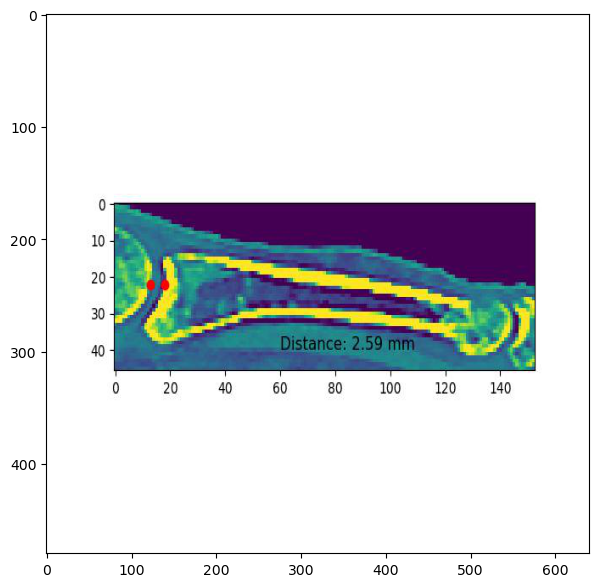

In [137]:
%matplotlib inline
plt.figure(figsize=(7, 7))
image_11 = Image.open('marked_image_s.jpg')
plt.imshow(image_11, aspect='auto') #
#plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()